# Euro Coin Detection and Value Estimation on A4

## 1. Introduction / problem description

In this notebook we develop a robust computer-vision pipeline in Python to detect and classify Euro coins lying on a DIN A4 sheet of paper.

**Input**

- A single RGB photo of Euro coins lying on a DIN A4 sheet (210 × 297 mm).
- The camera viewpoint, illumination (shadows, brightness), and number / arrangement of coins may vary.

**Goals**

1. Detect the A4 sheet and rectify the image to a top-down, metric view using a projective homography.
2. Detect all coins on the rectified A4 image.
3. Measure each coin’s diameter in millimetres using the known A4 size as a reference.
4. Classify each detected coin into the correct Euro denomination  
   (1c, 2c, 5c, 10c, 20c, 50c, 1€, 2€).
5. Compute the total value of all coins, e.g. `Total detected value = € 3.81`.
6. Make the pipeline robust against:
   - moderate shadows and illumination changes,
   - small noise / extra small objects on the paper,
   - missing or wrong detections.

If a critical step fails (e.g. A4 not found, segmentation too noisy), the notebook should **raise a clear error or warning** instead of silently producing wrong results.

---

## 2. Imports and basic helper functions


In [2]:
# ================================================================
# 2. Imports and helper functions
# ================================================================

from pathlib import Path
from dataclasses import dataclass

import warnings

import cv2
import numpy as np
import matplotlib.pyplot as plt


# Make plots appear larger and a bit nicer inside the notebook
plt.rcParams["figure.figsize"] = (8, 6)
plt.rcParams["image.cmap"] = "gray"
plt.rcParams["axes.grid"] = False


def show(img: np.ndarray, title: str = "", cmap: str | None = None) -> None:
    """
    Display an image (grayscale or BGR color) inside the notebook.

    Parameters
    ----------
    img : np.ndarray
        Image to display. Can be a 2D grayscale array or a 3D BGR color image
        as returned by OpenCV (shape: H×W×3, dtype uint8).
    title : str, optional
        Title text shown above the image.
    cmap : str or None, optional
        Matplotlib colormap to use for grayscale images. If None, a default
        grayscale colormap is used. This argument is ignored for color images.

    Notes
    -----
    OpenCV uses BGR channel order, while Matplotlib expects RGB.
    For 3-channel images we automatically convert from BGR to RGB
    before displaying.
    """
    plt.figure()

    if img.ndim == 2:
        # Grayscale image
        plt.imshow(img, cmap=cmap or "gray")
    elif img.ndim == 3 and img.shape[2] == 3:
        # Color image in BGR → convert to RGB for Matplotlib
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.imshow(img_rgb)
    else:
        raise ValueError(
            f"Unsupported image shape {img.shape!r}. Expected 2D grayscale "
            "or 3D BGR color image with 3 channels."
        )

    if title:
        plt.title(title)
    plt.axis("off")
    plt.show()


## 3. Configuration and data paths

In this section we define:

- Paths to the input images.
- The physical dimensions of a DIN A4 sheet in millimetres.
- An initial guess for the pixel density (`PIXELS_PER_MM`) of the rectified A4 view.
- The true diameters and monetary values of Euro coins.

The A4 dimensions and Euro diameters will later allow us to convert measured
pixel diameters into millimetres and classify each coin by its physical size.


In [3]:
# ================================================================
# 3. Configuration and data paths
# ================================================================

# Base directory for input images (adapt this to your folder structure)
DATA_DIR = Path("data")  # e.g. notebook_folder / "data"

# Single example image for development
# TODO: adjust this filename to match your actual file
IMAGE_PATH = DATA_DIR / "euros1.jpeg"

# --- A4 sheet dimensions in millimetres ---
A4_WIDTH_MM = 210.0   # short side
A4_HEIGHT_MM = 297.0  # long side

# --- Pixel density of the rectified A4 image ---
# This controls the resolution of the warped, top-down A4 view.
# Example: 8 pixels per millimetre → about 1680 x 2376 pixels for A4.
PIXELS_PER_MM = 8.0

# Derived output size for the rectified A4 image (in pixels)
A4_WIDTH_PX = int(round(A4_WIDTH_MM * PIXELS_PER_MM))
A4_HEIGHT_PX = int(round(A4_HEIGHT_MM * PIXELS_PER_MM))

print(f"A4 rectified size: {A4_WIDTH_PX} x {A4_HEIGHT_PX} px")


# --- Euro coin diameters in millimetres (official nominal values) ---
EURO_MM = {
    "1c":  16.25,
    "2c":  18.75,
    "5c":  21.25,
    "10c": 19.75,
    "20c": 22.25,
    "50c": 24.25,
    "1e":  23.25,
    "2e":  25.75,
}

# --- Euro coin values in Euro ---
EURO_VAL = {
    "1c":  0.01,
    "2c":  0.02,
    "5c":  0.05,
    "10c": 0.10,
    "20c": 0.20,
    "50c": 0.50,
    "1e":  1.00,
    "2e":  2.00,
}

print("Defined Euro coin diameters (mm):")
for k, v in EURO_MM.items():
    print(f"  {k:>2} : {v:5.2f} mm")

print("\nDefined Euro coin values (€):")
for k, v in EURO_VAL.items():
    print(f"  {k:>2} : {v:4.2f} €")


A4 rectified size: 1680 x 2376 px
Defined Euro coin diameters (mm):
  1c : 16.25 mm
  2c : 18.75 mm
  5c : 21.25 mm
  10c : 19.75 mm
  20c : 22.25 mm
  50c : 24.25 mm
  1e : 23.25 mm
  2e : 25.75 mm

Defined Euro coin values (€):
  1c : 0.01 €
  2c : 0.02 €
  5c : 0.05 €
  10c : 0.10 €
  20c : 0.20 €
  50c : 0.50 €
  1e : 1.00 €
  2e : 2.00 €


## 4. Image loading and inspection

We begin by loading one example image using OpenCV (`cv2.imread`).  
We print the image shape to verify that the file exists and has the expected
dimensions, and we display it to visually confirm orientation, brightness,
and the presence of the A4 sheet and coins.

Important checks:

- If `cv2.imread(...)` returns `None`, the path is wrong.
- The image should have shape `(H, W, 3)` with dtype `uint8`.
- The A4 sheet should be visible and mostly brighter than the background.


Loaded image: euros1.jpeg
Shape: (5712, 4284, 3), dtype: uint8


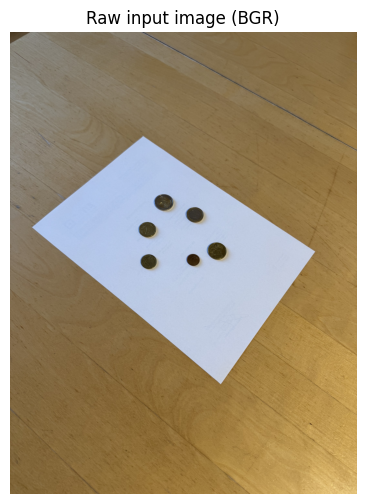

In [4]:
# ================================================================
# 4. Image loading and inspection
# ================================================================

# Try to load the image
img_bgr = cv2.imread(str(IMAGE_PATH))

if img_bgr is None:
    raise FileNotFoundError(f"Could not load image: {IMAGE_PATH}")

print(f"Loaded image: {IMAGE_PATH.name}")
print(f"Shape: {img_bgr.shape}, dtype: {img_bgr.dtype}")

# Show the raw BGR image (converted to RGB inside show())
show(img_bgr, title="Raw input image (BGR)")


## 5.1 A4 detection – grayscale, blur, and Otsu threshold

We detect the A4 sheet by separating it from the darker wooden table.  
A4 paper is highly reflective and bright, so simple global thresholding with
Otsu's method is effective.

Steps:
1. Convert the image to grayscale.
2. Apply a Gaussian blur to suppress small details (coins, texture).
3. Apply Otsu thresholding (`THRESH_BINARY`) to separate bright paper (white)
   from darker background (black).

This creates a clean mask where the A4 sheet should appear as the largest
white region.


Thresholding complete.
White pixels in mask: 5951352


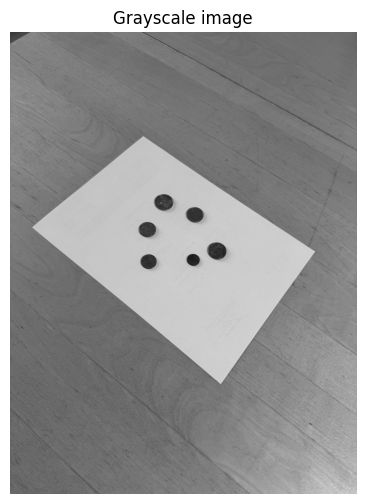

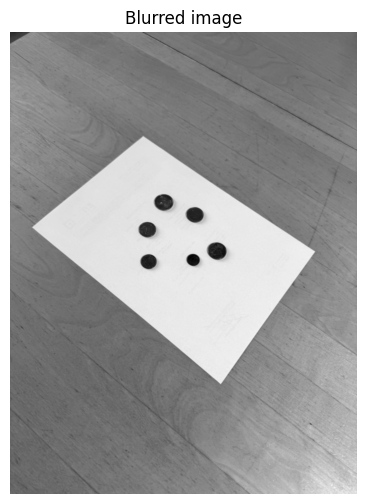

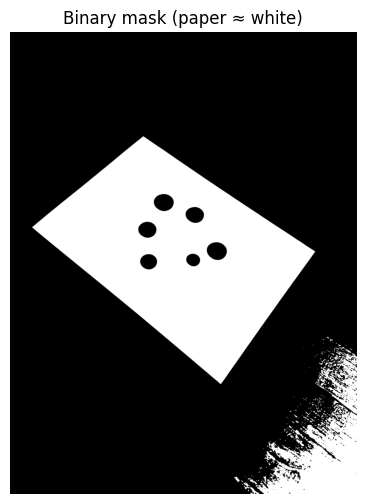

In [5]:
# ================================================================
# 5.1 A4 detection – grayscale, blur, Otsu threshold
# ================================================================

# Convert to grayscale
img_gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)

# Gaussian blur to remove coins & noise
img_blur = cv2.GaussianBlur(img_gray, (21, 21), 0)

# Otsu threshold: paper should become white
_, mask_paper = cv2.threshold(
    img_blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU
)

print("Thresholding complete.")
print("White pixels in mask:", np.sum(mask_paper == 255))

# Visualize
show(img_gray, title="Grayscale image")
show(img_blur, title="Blurred image")
show(mask_paper, title="Binary mask (paper ≈ white)")


## 5.2 Find the largest convex quadrilateral (A4 sheet)

We extract contours from the binary mask and search for the A4 sheet.

Approach:

1. Find all external contours.
2. Approximate each contour using `cv2.approxPolyDP`.
3. Keep contours that:
   - have exactly 4 vertices,
   - are convex,
   - have a large area.
4. Select the largest quadrilateral as the A4 sheet.

This function returns the four corner points in image pixel coordinates.
If no valid quadrilateral is found, the function raises a clear exception.


Largest quadrilateral area: 5181733 px²
Detected quad points:
[[1642 1290]
 [ 274 2414]
 [2602 4351]
 [3766 2715]]


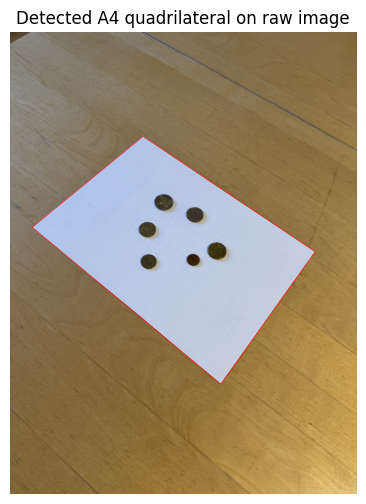

In [6]:
# ================================================================
# 5.2 Find the largest convex quadrilateral from the binary mask
# ================================================================

def find_largest_quad_from_binary(mask: np.ndarray):
    """
    Find the largest convex quadrilateral in a binary mask.

    Parameters
    ----------
    mask : np.ndarray
        A binary image (uint8) where the A4 sheet should appear as a white region.

    Returns
    -------
    quad : np.ndarray of shape (4, 2)
        The corner points (x, y) of the largest detected quadrilateral.

    Raises
    ------
    ValueError
        If no suitable quadrilateral is found.
    """
    # Find contours (external only)
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if not contours:
        raise ValueError("No contours found in mask — A4 detection failed.")

    best_area = 0
    best_quad = None

    for cnt in contours:
        area = cv2.contourArea(cnt)
        if area < 10000:  # ignore tiny objects
            continue

        # Polygon approximation
        peri = cv2.arcLength(cnt, True)
        approx = cv2.approxPolyDP(cnt, 0.02 * peri, True)

        # Keep convex quadrilaterals only
        if len(approx) == 4 and cv2.isContourConvex(approx):
            if area > best_area:
                best_area = area
                best_quad = approx.reshape(4, 2)

    if best_quad is None:
        raise ValueError("No convex quadrilateral found — check segmentation or lighting.")

    print(f"Largest quadrilateral area: {best_area:.0f} px²")
    return best_quad


# --- Run the function on our mask ---
quad = find_largest_quad_from_binary(mask_paper)

print("Detected quad points:")
print(quad)

# Visualize the detected quadrilateral on the original image
img_quad_vis = img_bgr.copy()
cv2.polylines(img_quad_vis, [quad.reshape(-1, 1, 2)], True, (0, 0, 255), 5)
show(img_quad_vis, title="Detected A4 quadrilateral on raw image")


## 5.3 Order the A4 corners (top-left, top-right, bottom-right, bottom-left)

The detected quadrilateral consists of four points in arbitrary order.
For the homography we need a **consistent ordering**:

1. top-left (TL)
2. top-right (TR)
3. bottom-right (BR)
4. bottom-left (BL)

A common strategy is:

- Compute the sum `s = x + y` for each point:
  - smallest sum → top-left,
  - largest sum → bottom-right.
- Compute the difference `d = x − y`:
  - smallest difference → top-right,
  - largest difference → bottom-left.

This assumes a standard image coordinate system with `x` to the right and
`y` downwards, which is the case for OpenCV images.


Ordered quad points (TL, TR, BR, BL):
[[ 274. 2414.]
 [1642. 1290.]
 [3766. 2715.]
 [2602. 4351.]]


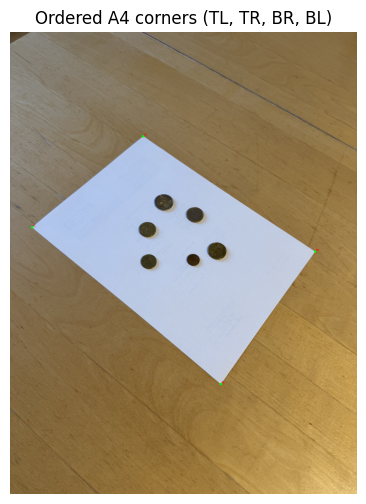

In [7]:
# ================================================================
# 5.3 Order corners (TL, TR, BR, BL)
# ================================================================

def order_corners(pts: np.ndarray) -> np.ndarray:
    """
    Robustly order four corner points (TL, TR, BR, BL) using centroid + angle.

    Parameters
    ----------
    pts : ndarray of shape (4, 2)

    Returns
    -------
    ordered : ndarray of shape (4, 2)
        Ordered points (TL, TR, BR, BL).
    """
    pts = np.asarray(pts, dtype=np.float32)
    if pts.shape != (4, 2):
        raise ValueError("Expected shape (4,2)")

    # Compute centroid
    cx = np.mean(pts[:, 0])
    cy = np.mean(pts[:, 1])

    # Compute angle of each point wrt centroid
    angles = np.arctan2(pts[:, 1] - cy, pts[:, 0] - cx)
    # Sort by angle (counterclockwise)
    idx = np.argsort(angles)
    pts_sorted = pts[idx]

    # After sorting:
    # pts_sorted[0] = BL
    # pts_sorted[1] = TL
    # pts_sorted[2] = TR
    # pts_sorted[3] = BR
    # (depending on orientation)

    # Identify TL as point with smallest (x+y)
    s = pts_sorted.sum(axis=1)
    tl_idx = np.argmin(s)
    # rotate array so tl_idx becomes position 0
    pts_rotated = np.roll(pts_sorted, -tl_idx, axis=0)

    # Now order is (TL, ?, ?, ?)
    # Next points in CCW order: TR, BR, BL
    TL = pts_rotated[0]
    TR = pts_rotated[1]
    BR = pts_rotated[2]
    BL = pts_rotated[3]

    return np.stack([TL, TR, BR, BL], axis=0)



# Apply ordering to the detected quadrilateral
quad_ordered = order_corners(quad)

print("Ordered quad points (TL, TR, BR, BL):")
print(quad_ordered)

# Visualize with labels
labels = ["TL", "TR", "BR", "BL"]
img_corners_vis = img_bgr.copy()

for (x, y), label in zip(quad_ordered, labels):
    x_i, y_i = int(x), int(y)
    cv2.circle(img_corners_vis, (x_i, y_i), 15, (0, 255, 0), -1)
    cv2.putText(
        img_corners_vis,
        label,
        (x_i + 10, y_i - 10),
        cv2.FONT_HERSHEY_SIMPLEX,
        1.0,
        (0, 0, 255),
        2,
        cv2.LINE_AA,
    )

show(img_corners_vis, title="Ordered A4 corners (TL, TR, BR, BL)")


## 5.4 Homography and 5.5 Rectified A4 image

Given the ordered A4 corners in the original image (TL, TR, BR, BL) and the
desired metric size of the A4 sheet in pixels, we can compute a projective
homography \( H \) that maps between the two.

- **Source points**: the 4 detected A4 corners in the input image.
- **Destination points**: the 4 corners of an axis-aligned A4 rectangle of size  
  `A4_WIDTH_PX × A4_HEIGHT_PX` pixels.

We then apply `cv2.warpPerspective` to obtain:

- `img_rect_bgr` – a top-down, metric view of the A4 sheet in BGR,
- `img_rect_gray` – its grayscale version.

In the rectified image:

- the A4 borders should be parallel to the image axes,
- the physical scale is approximately `PIXELS_PER_MM`,
- coins should appear undistorted and circular.


Homography matrix H:
[[ 7.20287578e-01 -8.65683780e-01  1.89240185e+03]
 [ 8.26600912e-01  1.00604097e+00 -2.65507155e+03]
 [-2.36733143e-05  1.59123584e-04  1.00000000e+00]]
Inlier mask from findHomography: [1, 1, 1, 1]
Rectified image shape: (2376, 1680, 3)


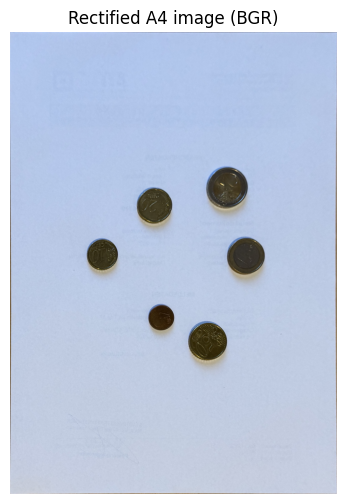

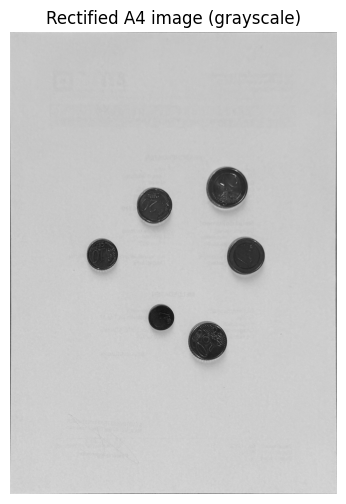

In [8]:
# ================================================================
# 5.4 Homography and rectified A4 image
# ================================================================

# Source points: detected A4 corners in original image (TL, TR, BR, BL)
src_pts = quad_ordered.astype(np.float32)

# Destination points: axis-aligned A4 rectangle in the rectified image
dst_pts = np.array(
    [
        [0, 0],                           # TL
        [A4_WIDTH_PX - 1, 0],             # TR
        [A4_WIDTH_PX - 1, A4_HEIGHT_PX - 1],  # BR
        [0, A4_HEIGHT_PX - 1],            # BL
    ],
    dtype=np.float32,
)

# Compute homography (image → rectified A4)
H, status = cv2.findHomography(src_pts, dst_pts)

if H is None:
    raise RuntimeError("Homography computation failed (H is None).")

print("Homography matrix H:")
print(H)
print("Inlier mask from findHomography:", status.ravel().tolist())

# Warp original image to obtain top-down view of A4
img_rect_bgr = cv2.warpPerspective(
    img_bgr, H, (A4_WIDTH_PX, A4_HEIGHT_PX)
)

# Also prepare a grayscale version of the rectified image
img_rect_gray = cv2.cvtColor(img_rect_bgr, cv2.COLOR_BGR2GRAY)

print("Rectified image shape:", img_rect_bgr.shape)

show(img_rect_bgr, title="Rectified A4 image (BGR)")
show(img_rect_gray, title="Rectified A4 image (grayscale)")


## 6.1 Coin segmentation – blur and Otsu threshold

We now segment the coins in the rectified A4 image.

**Goal:** coins = white, background = black.

Steps:

1. Apply a strong Gaussian blur (e.g. 21×21 kernel).  
   This removes all text, texture and reduces shadows.
2. Apply global Otsu thresholding with `THRESH_BINARY_INV` so that
   dark coins become white foreground objects.
3. Perform a simple check:
   - If the number of white pixels is extremely small, segmentation failed.

This gives a raw binary mask that we will refine further.


White pixels (coins) in raw mask: 160395


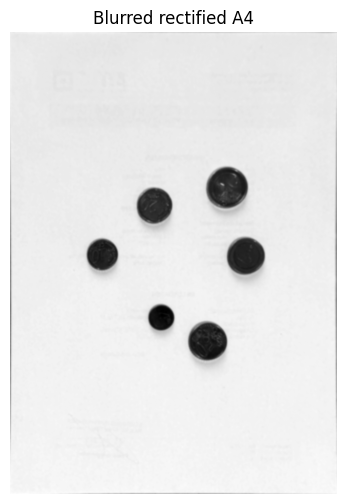

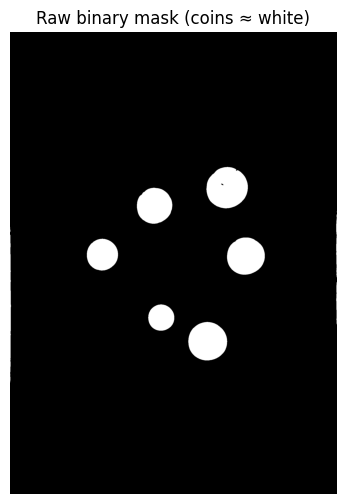

In [9]:
# ================================================================
# 6.1 Coin segmentation – blur and Otsu threshold
# ================================================================

def blur_and_threshold_otsu(img_gray: np.ndarray) -> np.ndarray:
    """
    Blur the grayscale image and apply Otsu inverse thresholding.
    
    Parameters
    ----------
    img_gray : np.ndarray
        Rectified grayscale A4 image.

    Returns
    -------
    mask : np.ndarray
        Binary mask where coins are white (255) and background is black (0).

    Raises
    ------
    RuntimeError
        If too few white pixels exist → segmentation failure.
    """
    # Strong blur to remove background texture
    blur = cv2.GaussianBlur(img_gray, (21, 21), 0)

    # Inverse Otsu: coins should be dark → become white
    _, mask = cv2.threshold(
        blur, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU
    )

    white_count = np.sum(mask == 255)
    if white_count < 500:  # arbitrary small sanity threshold
        raise RuntimeError(
            f"Segmentation failed: too few foreground pixels ({white_count})."
        )

    return blur, mask


# Run the segmentation
img_blur2, mask_coins_raw = blur_and_threshold_otsu(img_rect_gray)

print("White pixels (coins) in raw mask:", np.sum(mask_coins_raw == 255))

show(img_blur2, title="Blurred rectified A4")
show(mask_coins_raw, title="Raw binary mask (coins ≈ white)")


## 6.2 Morphological refinement

Although the raw thresholded mask already captures the coins well,
small imperfections can still occur (tiny speckles, small holes,
rough boundaries).

To improve stability before connected-component analysis, we apply:

- **Opening** with a small kernel to remove isolated noise.
- **Closing** with a larger kernel to fill small gaps inside blobs.

This produces a cleaner mask where each coin is a single connected,
compact region, which makes area and circularity measurements reliable.


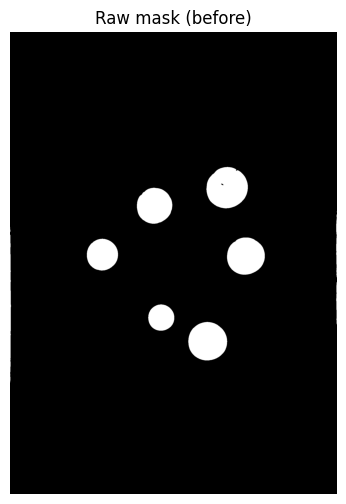

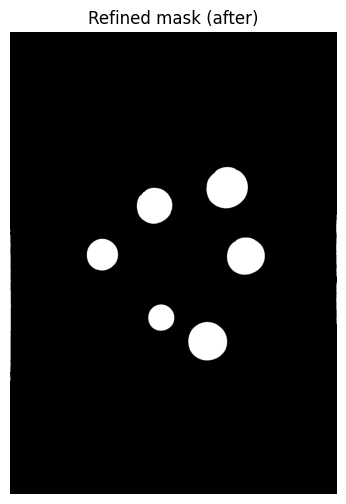

In [10]:
# ================================================================
# 6.2 Morphological refinement
# ================================================================

def refine_coin_mask(mask: np.ndarray) -> np.ndarray:
    """
    Apply morphological operations to clean up the coin mask.

    Parameters
    ----------
    mask : np.ndarray
        Binary mask (coins are white: 255)

    Returns
    -------
    refined : np.ndarray
        Morphologically cleaned binary mask.
    """
    # Small opening to remove tiny specks (3x3)
    kernel_open = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
    opened = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel_open)

    # Larger closing to fill gaps and smooth shapes (11x11)
    kernel_close = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (11, 11))
    refined = cv2.morphologyEx(opened, cv2.MORPH_CLOSE, kernel_close)

    return refined


# Apply refinement
mask_coins_refined = refine_coin_mask(mask_coins_raw)

show(mask_coins_raw,     title="Raw mask (before)")
show(mask_coins_refined, title="Refined mask (after)")


## 6.3 Connected components

We now identify each individual coin as a connected component in the refined
binary mask.

Using `cv2.connectedComponentsWithStats` we obtain:

- the number of labels,
- per-component statistics (area, bounding box),
- centroids.

We ignore label **0** (the background) and keep only the foreground
components (the coins).

A small sanity check:

- If we detect zero components → segmentation failed.
- If we detect a very large number (e.g. > 50) → probably noise or bad threshold.

We also visualize the detected components by drawing colored contours on the
rectified A4 image.


Num labels (including background): 13
Foreground components (coins expected): 12


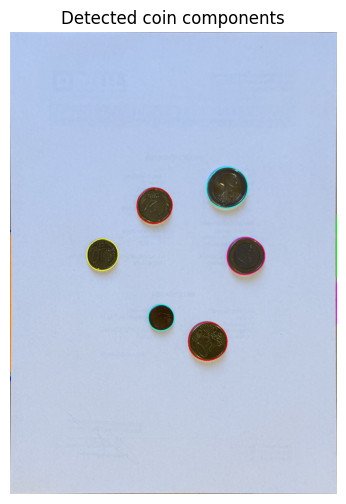

In [11]:
# ================================================================
# 6.3 Connected components
# ================================================================

def find_connected_components(mask: np.ndarray):
    """
    Wrapper around cv2.connectedComponentsWithStats.

    Parameters
    ----------
    mask : np.ndarray
        Binary mask (coins = white = 255)

    Returns
    -------
    num_labels : int
    labels : np.ndarray
    stats : np.ndarray
    centroids : np.ndarray
    """
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(
        mask, connectivity=8
    )
    return num_labels, labels, stats, centroids


# Run connected components
num_labels, labels, stats, centroids = find_connected_components(mask_coins_refined)

print(f"Num labels (including background): {num_labels}")

# foreground labels = 1 ... num_labels-1
num_coins_detected = num_labels - 1
print(f"Foreground components (coins expected): {num_coins_detected}")

if num_coins_detected == 0:
    raise RuntimeError("No coins detected after connected components.")

if num_coins_detected > 50:
    warnings.warn(
        f"Detected {num_coins_detected} components → segmentation likely noisy."
    )

# Visualize components by drawing contours
img_components_vis = img_rect_bgr.copy()
colors = [
    (255, 0, 0),
    (0, 255, 0),
    (0, 0, 255),
    (255, 255, 0),
    (255, 0, 255),
    (0, 255, 255),
    (128, 0, 255),
    (0, 128, 255),
]

# For contour visualization, find contours from refined mask
contours, _ = cv2.findContours(
    mask_coins_refined, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
)

for i, cnt in enumerate(contours):
    cv2.drawContours(
        img_components_vis,
        [cnt],
        -1,
        colors[i % len(colors)],
        4
    )

show(img_components_vis, title="Detected coin components")


## 7. Feature extraction and candidate filtering

From the connected components, we now extract geometric features:

- area (in pixels),
- equivalent diameter (px and mm),
- circularity,
- centroid.

We define a `CoinCandidate` dataclass to store all information, and we
filter components using physically meaningful constraints:

- Component area must fall inside the theoretical pixel area range of all
  Euro coins.
- Circularity must be high (coins are nearly perfect circles).
- Diameter must be reasonable once converted to millimetres.

This step eliminates small noise components and keeps only true coins.


In [12]:
# ================================================================
# 7.1 Dataclass + expected area range
# ================================================================

@dataclass
class CoinCandidate:
    label: int
    area_px: int
    diameter_px: float
    diameter_mm: float
    circularity: float
    center: tuple


def expected_area_range(px_per_mm: float):
    """
    Compute the minimum and maximum expected coin areas in pixels,
    based on true Euro coin diameters and pixel density.

    Returns
    -------
    (area_min, area_max) : tuple of floats
    """
    diam_mm_values = list(EURO_MM.values())
    diam_px_values = [d * px_per_mm for d in diam_mm_values]

    areas = [np.pi * (d/2)**2 for d in diam_px_values]
    return min(areas) * 0.6, max(areas) * 1.4  # margin for safety


area_min_px, area_max_px = expected_area_range(PIXELS_PER_MM)
print("Expected area range (px):", area_min_px, area_max_px)


Expected area range (px): 7963.9373768501255 46660.81904670776


In [13]:
# ================================================================
# 7.2 Extract features and filter components
# ================================================================

coin_candidates = []

for label_idx in range(1, num_labels):  # skip background=0
    area = stats[label_idx, cv2.CC_STAT_AREA]

    # filter by area
    if area < area_min_px or area > area_max_px:
        continue  # skip noise

    # extract contour for circularity
    mask_component = (labels == label_idx).astype(np.uint8) * 255
    cnts, _ = cv2.findContours(mask_component, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if len(cnts) == 0:
        continue
    cnt = cnts[0]

    perimeter = cv2.arcLength(cnt, True)
    if perimeter == 0:
        continue

    circularity = 4 * np.pi * area / (perimeter * perimeter)

    # circularity threshold
    if circularity < 0.7:
        continue

    # equivalent diameter in pixels
    diameter_px = 2 * np.sqrt(area / np.pi)

    # convert to mm
    diameter_mm = diameter_px / PIXELS_PER_MM

    cx, cy = centroids[label_idx]

    candidate = CoinCandidate(
        label=label_idx,
        area_px=area,
        diameter_px=diameter_px,
        diameter_mm=diameter_mm,
        circularity=circularity,
        center=(cx, cy)
    )

    coin_candidates.append(candidate)


print(f"Valid coin candidates: {len(coin_candidates)}")
for c in coin_candidates:
    print(
        f"label={c.label}, area={c.area_px}, dia_mm={c.diameter_mm:.2f}, "
        f"circ={c.circularity:.3f}"
    )


Valid coin candidates: 6
label=1, area=35244, dia_mm=26.48, circ=0.903
label=2, area=26284, dia_mm=22.87, circ=0.902
label=6, area=29210, dia_mm=24.11, circ=0.906
label=7, area=20530, dia_mm=20.21, circ=0.905
label=9, area=14257, dia_mm=16.84, circ=0.910
label=10, area=31068, dia_mm=24.86, circ=0.905


## 8. Classification of coins and diameter calibration

We now convert the measured diameters into Euro coin types.

Steps:

1. Use the true Euro diameters (`EURO_MM`) and values (`EURO_VAL`).
2. Introduce a global **calibration factor** to correct systematic bias
   in the measured diameters (e.g. due to lens distortion or A4 size
   mismatch). Here we use a simple scale factor `CALIBRATION_FACTOR`.
3. For each detected coin candidate:
   - compute a calibrated diameter in mm,
   - compare it to all true Euro diameters,
   - choose the closest match,
   - compute the absolute diameter error,
   - assign the corresponding monetary value.

We also compute summary statistics of the diameter error and issue
warnings when the error becomes large.


In [14]:
# ================================================================
# 8. Classification and calibration
# ================================================================

CALIBRATION_FACTOR = 0.97  # simple global scale factor for diameters


def calibrate_diameter(d_mm: float, factor: float = CALIBRATION_FACTOR) -> float:
    """
    Apply a simple global scale factor to a measured diameter.

    Parameters
    ----------
    d_mm : float
        Measured diameter in millimetres.
    factor : float
        Calibration factor (typically slightly < 1.0).

    Returns
    -------
    float
        Calibrated diameter in millimetres.
    """
    return factor * d_mm


def classify_coin_by_diameter(d_mm: float):
    """
    Classify a coin by its (calibrated) diameter in mm.

    Parameters
    ----------
    d_mm : float
        Calibrated diameter in millimetres.

    Returns
    -------
    coin_type : str
        One of the keys in EURO_MM, or "unknown" if no close match.
    error_mm : float
        Absolute difference between d_mm and the matched nominal diameter.
    """
    # Find nearest Euro diameter
    best_type = None
    best_error = float("inf")

    for coin_type, true_d in EURO_MM.items():
        err = abs(d_mm - true_d)
        if err < best_error:
            best_error = err
            best_type = coin_type

    # If the error is very large, mark as unknown (out of Euro range)
    if best_error > 1.5:  # mm
        return "unknown", best_error

    return best_type, best_error


# --- Apply classification to all candidates ---

classified_coins = []
total_value = 0.0
errors_mm = []

print("Calibrated classification:")

for c in coin_candidates:
    d_raw = c.diameter_mm
    d_cal = calibrate_diameter(d_raw, CALIBRATION_FACTOR)
    coin_type, err_mm = classify_coin_by_diameter(d_cal)

    value = EURO_VAL.get(coin_type, 0.0)
    total_value += value
    errors_mm.append(err_mm)

    classified_coins.append(
        {
            "candidate": c,
            "coin_type": coin_type,
            "diameter_mm_raw": d_raw,
            "diameter_mm_calib": d_cal,
            "error_mm": err_mm,
            "value_eur": value,
        }
    )

    print(
        f"{coin_type:>7} | d_raw = {d_raw:5.2f} mm -> "
        f"d_cal = {d_cal:5.2f} mm (error = {err_mm:4.2f} mm) | "
        f"value = {value:4.2f} €"
    )

print(f"\nTotal detected value: {total_value:.2f} €")

if errors_mm:
    mean_err = float(np.mean(errors_mm))
    max_err = float(np.max(errors_mm))
    print(f"\nDiameter error (calibrated): mean = {mean_err:.2f} mm, max = {max_err:.2f} mm")

    if max_err > 1.0:
        warnings.warn("Diameter error high; classification may be unreliable.")


Calibrated classification:
     2e | d_raw = 26.48 mm -> d_cal = 25.68 mm (error = 0.07 mm) | value = 2.00 €
    20c | d_raw = 22.87 mm -> d_cal = 22.18 mm (error = 0.07 mm) | value = 0.20 €
     1e | d_raw = 24.11 mm -> d_cal = 23.38 mm (error = 0.13 mm) | value = 1.00 €
    10c | d_raw = 20.21 mm -> d_cal = 19.60 mm (error = 0.15 mm) | value = 0.10 €
     1c | d_raw = 16.84 mm -> d_cal = 16.34 mm (error = 0.09 mm) | value = 0.01 €
    50c | d_raw = 24.86 mm -> d_cal = 24.12 mm (error = 0.13 mm) | value = 0.50 €

Total detected value: 3.81 €

Diameter error (calibrated): mean = 0.11 mm, max = 0.15 mm


### 8.5 Visualization of classified coins

We now overlay the classification results on the rectified A4 image by
drawing the coin centres and short text labels (e.g. "1E", "2E") on top
of the coins.


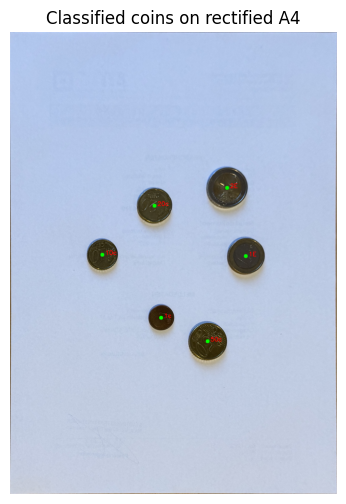

In [15]:
# ================================================================
# 8.5 Visualization of classified coins
# ================================================================

label_map = {
    "1c": "1c",
    "2c": "2c",
    "5c": "5c",
    "10c": "10c",
    "20c": "20c",
    "50c": "50c",
    "1e": "1E",
    "2e": "2E",
    "unknown": "UNK",
}

img_class_vis = img_rect_bgr.copy()

for entry in classified_coins:
    c = entry["candidate"]
    coin_type = entry["coin_type"]

    cx, cy = c.center
    cx_i, cy_i = int(round(cx)), int(round(cy))

    cv2.circle(img_class_vis, (cx_i, cy_i), 10, (0, 255, 0), -1)

    txt = label_map.get(coin_type, "UNK")
    cv2.putText(
        img_class_vis,
        txt,
        (cx_i + 15, cy_i),
        cv2.FONT_HERSHEY_SIMPLEX,
        1.0,
        (0, 0, 255),
        2,
        cv2.LINE_AA,
    )

show(img_class_vis, title="Classified coins on rectified A4")
